In [ ]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

: 

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score, StratifiedKFold 
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.metrics import silhouette_score, classification_report, confusion_matrix, accuracy_score, f1_score, mean_squared_error, mean_absolute_error, r2_score
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectFromModel
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [ ]:
file_path = '../data/processed/Juegorawg_limpio.csv'
df = pd.read_csv(file_path)
df.copy()

In [ ]:
print(f"Dimensiones del dataset: {df.shape}")
print("\nEstadísticas descriptivas de rating:")
print(df['rating'].describe())

# Preprocesamiento

In [ ]:
print("\n" + "="*50)
print("Preprocesamiento")
print("="*50)

## Crear categorías de rating para clasificación

In [ ]:
rating_bins = [0, 2.5, 3.5, 5]
rating_labels = ['Bajo', 'Medio', 'Alto']
df['rating_category'] = pd.cut(df['rating'], bins=rating_bins, labels=rating_labels)

# Verificar valores nulos en rating_category

In [ ]:
print("\nnulos en rating_category:", df['rating_category'].isnull().sum())

# imputar los valores nulos en rating_category
- Aqui use los valores de rating normal

In [ ]:
df.loc[df['rating_category'].isnull() & (df['rating'] <= 2.5), 'rating_category'] = 'Bajo'
df.loc[df['rating_category'].isnull() & (df['rating'] > 2.5) & (df['rating'] <= 3.5), 'rating_category'] = 'Medio'
df.loc[df['rating_category'].isnull() & (df['rating'] > 3.5), 'rating_category'] = 'Alto'

In [ ]:
print("Valores nulos después de imputación:", df['rating_category'].isnull().sum())
print("\nDistribución de categorías de rating después de imputación:")
print(df['rating_category'].value_counts())

# Crear características derivadas

In [ ]:
df['rating_to_count_ratio'] = df['rating'] / (df['ratings_count'] + 1)  # +1 para evitar división por cero
df['reviews_to_ratings_ratio'] = df['reviews_count'] / (df['ratings_count'] + 1)
df['popularity_score'] = (df['ratings_count'] + df['reviews_count'] + df['added']) / 3
df['recency_factor'] = 2025 - df['release_year']  # Cuán reciente es el juego

# Usar las características seleccionadas

In [ ]:
# Características numéricas relevantes
selected_features = [
    'playtime',           # Tiempo de juego promedio
    'metacritic',         # Puntuación de críticos profesionales
    'ratings_count',      # Número de calificaciones (popularidad)
    'reviews_count',      # Número de reseñas
    'added',              # Veces que el juego fue añadido
    'suggestions_count',  # Número de sugerencias
    'release_year',       # Año de lanzamiento
    'rating_to_count_ratio',    # Tus características derivadas
    'reviews_to_ratings_ratio',
    'popularity_score',
    'recency_factor'
]

# Características categóricas para codificar
categorical_features = [
    'main_genre',          # Género principal del juego
    'metacritic_category'  # Categoría de Metacritic
]


In [ ]:
X_selected = df[selected_features].copy()

In [ ]:
X_cat = df[categorical_features].copy()

- trabajamos las cetegoricas

In [ ]:
label_encoders = {}

# Aplicar LabelEncoder a cada columna categórica
for col in categorical_features:
    le = LabelEncoder()
    X_cat[col] = le.fit_transform(X_cat[col])
    label_encoders[col] = le


Combinamos las caracteristicas

In [ ]:
X_combined = pd.concat([X_selected, X_cat], axis=1)

In [ ]:
X_combined

In [ ]:
# X_combined.to_csv('Videojuegos_ml',
#                   index=False,              # No incluir el índice
#           sep=',',                  # Separador (puede ser ';' u otro)
#           decimal='.',              # Punto decimal
#           encoding='utf-8')

# Variable objetivo
- 'rating_category'

### Variable ojbetivo 

In [ ]:
label_encoder_target = LabelEncoder()
y = label_encoder_target.fit_transform(df['rating_category'])

# Entrenar un RandomForestClassifier para calcular la importancia de las características

In [ ]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_combined, y)

# Obtener la importancia de las características
important_features = pd.Series(rf.feature_importances_, index=X_combined.columns)
important_features = important_features.sort_values(ascending=False)

# Mostrar los resultados visualmente

In [ ]:
plt.figure(figsize=(10, 5))
important_features.plot(kind='bar')
plt.title("Importancia de las Características")
plt.xlabel("Características")
plt.ylabel("Importancia")
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

## Ya tenemos las mas importantes 

In [ ]:
important_features = [
    'rating_to_count_ratio',
    'reviews_count',
    'ratings_count',
    'reviews_to_ratings_ratio',
    'added'
]

# Usar solo estas características

In [ ]:
X_selected = df[important_features].copy()

# Escalar las características

In [ ]:
scaler = StandardScaler()
X = scaler.fit_transform(X_selected)
le = LabelEncoder()
y = le.fit_transform(df['rating_category'])

## Dividimos el conjunto de pruebas

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

#  SELECCIÓN POR VARIANZA ACUMULADA

In [ ]:
# Aplicar PCA
pca = PCA()
pca.fit(X_train)

In [ ]:
# Calcular varianza acumulada
var_ratio = pca.explained_variance_ratio_
cum_var_ratio = np.cumsum(var_ratio)

# Visualizar la varianza acumulada
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cum_var_ratio) + 1), cum_var_ratio, marker='o', linestyle='-')
plt.xlabel('Número de Componentes')
plt.ylabel('Varianza Acumulada')
plt.title('Varianza Acumulada Explicada por Componentes')
plt.grid(True)
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Varianza')
plt.legend()
plt.tight_layout()
plt.show()

# Seleccionar características que explican el 95% de la varianza

In [ ]:
n_components = np.argmax(cum_var_ratio >= 0.95) + 1
print(f"Número de componentes para explicar el 95% de la varianza: {n_components}")

# Aplicar PCA con el número óptimo de componentes

In [ ]:
pca_optimal = PCA(n_components=n_components)
X_train_pca = pca_optimal.fit_transform(X_train)
X_test_pca = pca_optimal.transform(X_test)

In [ ]:
# Mostrar la forma de los nuevos conjuntos de datos
print(f"Forma de X_train_pca: {X_train_pca.shape}")
print(f"Forma de X_test_pca: {X_test_pca.shape}")

## Conclusion 

- Después de aplicar PCA con 4 componentes, los datos ahora tienen las siguientes dimensiones:
----
- X_train_pca: (3014, 4)
- X_test_pca: (754, 4)
- Esto significa que hemos reducido la cantidad de características de 5 a 4, reteniendo el 95% de la varianza.

In [ ]:
# Mostrar la contribución de cada característica original a los componentes principales
if n_components <= 5:  # Solo mostrar si tenemos pocos componentes
    components_df = pd.DataFrame(
        pca_optimal.components_,
        columns=important_features,
        index=[f'PC{i+1}' for i in range(n_components)]
    )
    print("\nContribución de cada característica a los componentes principales:")
    print(components_df)

## Resumen del Gráfico de Varianza Acumulada

- El gráfico muestra la varianza explicada por cada característica seleccionada y su acumulado.
- Algunas características contribuyen más que otras a la variabilidad total de los datos.
- La línea roja indica la varianza acumulada, ayudando a visualizar cuántas características son necesarias para explicar la mayor parte de la información.
- Se marca un umbral del **95% de varianza explicada**, útil para evaluar si se puede reducir la dimensionalidad sin perder información significativa.
- Si con menos características se alcanza el umbral del 95%, se puede simplificar el modelo, mejorando la eficiencia y evitando el sobreajuste.

- Aquí tienes la contribución de cada característica original a los 4 componentes principales. 🔍 Esto te ayuda a entender qué características originales influyen más en cada componente principal tras aplicar PCA.

En conclusión, este análisis confirma que las características seleccionadas son relevantes y permite identificar si algunas pueden ser eliminadas sin afectar significativamente el rendimiento del modelo.

# Clustering

### Determinar el número óptimo de clusters usando el método del codo y silhouette score

In [ ]:
print("\n===  MÉTODO DEL CODO Y SILUETA ===")
# Calcular inercia y puntuación de silueta para diferentes valores de k
inertias = []
silhouette_scores = []
k_range = range(2, 10)

In [ ]:
for k in k_range:
    # Entrenar K-means
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_train)

    # Guardar inercia
    inertias.append(kmeans.inertia_)

    # Calcular silhouette score
    if k > 1:  # Silhouette score requiere al menos 2 clusters
        labels = kmeans.predict(X_train)
        silhouette_scores.append(silhouette_score(X_train, labels))

# Visualizar el método del codo y silueta

In [ ]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(k_range, inertias, marker='o')
plt.xlabel('Número de clusters (k)')
plt.ylabel('Inercia')
plt.title('Método del Codo')
plt.grid(True)

# Interpretación:
1. El gráfico muestra cómo la inercia (distorsión) disminuye a medida que aumenta el número de clusters
2. El "codo" de la curva representa el punto óptimo donde añadir más clusters no mejora significativamente el modelo
3. Este punto de inflexión sugiere el número ideal de clusters para el conjunto de datos
4. Después del codo, la reducción en la inercia es menos pronunciada, indicando rendimientos decrecientes
- En resumen, este gráfico es fundamental para determinar el número óptimo de clusters en un análisis de K-means, buscando el equilibrio entre la complejidad del modelo y su capacidad explicativa.

In [ ]:
# Visualizar silhouette scores
plt.subplot(1, 2, 2)
plt.plot(list(k_range), silhouette_scores, marker='o')  # Corregido aquí
plt.xlabel('Número de clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score por Número de Clusters')
plt.grid(True)
plt.tight_layout()
plt.show()

# Interpretación:
1. El Silhouette Score mide qué tan similar es un objeto a su propio cluster en comparación con otros clusters
- Valores más cercanos a 1 indican:
- Mejor definición de clusters
- Mayor separación entre clusters
- Mejor cohesión dentro de cada cluster
2. Valores cercanos a 0 indican:
- Solapamiento entre clusters
- Clusters menos definidos
3. Valores negativos sugieren:
- Asignaciones incorrectas de puntos a clusters

#### En resumen, el número óptimo de clusters se puede identificar donde el Silhouette Score alcanza su valor máximo, indicando la mejor separación y cohesión de los clusters. Este análisis, junto con el método del codo, proporciona una base sólida para seleccionar el número apropiado de clusters en el análisis.

# Determinar el número óptimo de clusters

In [ ]:
optimal_k = k_range[silhouette_scores.index(max(silhouette_scores))]
print(f"Número óptimo de clusters según silhouette score: {optimal_k}")

In [ ]:
# Aplicar K-means con el número óptimo de clusters
kmeans_optimal = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
cluster_labels = kmeans_optimal.fit_predict(X_train)

In [ ]:
# Añadir etiquetas de cluster a los datos de entrenamiento
X_train_df = pd.DataFrame(X_train, columns=important_features)
X_train_df['cluster'] = cluster_labels
X_train_df['rating_category'] = le.inverse_transform(y_train)

In [ ]:
# Visualizar la distribución de categorías de rating por cluster
plt.figure(figsize=(12, 6))
for i in range(optimal_k):
    cluster_data = X_train_df[X_train_df['cluster'] == i]
    plt.subplot(1, optimal_k, i+1)
    sns.countplot(x='rating_category', data=cluster_data)
    plt.title(f'Cluster {i}')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Interpretación:
- Cada subgráfico representa un cluster diferente
- Las barras muestran la frecuencia de cada categoría de rating dentro del cluster
# Permite identificar:
- Patrones dominantes en cada cluster
- Diferencias en la distribución de ratings entre clusters
- Posibles sesgos o preferencias en cada grupo
# Utilidad del análisis:
- Ayuda a caracterizar cada cluster según sus patrones de rating
- Permite identificar segmentos de usuarios con preferencias similares
- Facilita la comprensión de comportamientos de calificación en diferentes grupos
- Puede usarse para estrategias de recomendación personalizadas

### En resumen, este gráfico es fundamental para entender cómo se distribuyen las preferencias de rating en cada cluster, lo que puede ser útil para la toma de decisiones en sistemas de recomendación o análisis de comportamiento de usuarios.

In [ ]:
# Visualizar los clusters en 2D (usando PCA)
plt.figure(figsize=(10, 8))
# Usar PCA para visualización en 2D
pca_viz = PCA(n_components=2)
X_train_pca_viz = pca_viz.fit_transform(X_train)

plt.scatter(X_train_pca_viz[:, 0], X_train_pca_viz[:, 1], c=cluster_labels, cmap='viridis', alpha=0.7)
plt.title(f'Visualización de {optimal_k} Clusters (PCA)')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.colorbar(label='Cluster')
plt.grid(True)
plt.show()

# Interpretación:
1. La distribución espacial de los puntos muestra:
- Separación entre clusters
- Densidad de cada cluster
- Posibles solapamientos entre grupos
2. Los colores diferentes ayudan a identificar:
- Fronteras entre clusters
- Patrones de agrupamiento
- Posibles outliers o puntos atípicos
3. Implicaciones del análisis:
- Permite evaluar visualmente la calidad de la clusterización
- Ayuda a identificar si los clusters están bien definidos o difusos
- Muestra la efectividad de la reducción dimensional mediante PCA
- Facilita la detección de patrones o estructuras en los datos

#### En resumen, este gráfico proporciona una representación visual intuitiva de cómo se agrupan los datos en el espacio bidimensional, lo que es crucial para validar la efectividad del algoritmo de clustering y comprender la estructura subyacente de los datos.

# Analizar la relación entre clusters y categorías de rating

In [ ]:
cluster_rating_cross = pd.crosstab(X_train_df['cluster'], X_train_df['rating_category'], normalize='index')
print("\nDistribución de categorías de rating por cluster (%):")
print(cluster_rating_cross * 100)

Aquí tienes la distribución de categorías de rating por cluster en porcentaje. 📊

Clusters 0 y 3 contienen exclusivamente juegos con rating Bajo (100%).
Clusters 1 y 2 tienen una mezcla de ratings, pero ambos están dominados por juegos Medio (~53-56%).
El Cluster 2 tiene una proporción ligeramente mayor de juegos con rating Alto (33.6%) en comparación con el Cluster 1 (30.6%).
Este análisis sugiere que los clusters capturan diferencias en la calidad de los juegos según el rating de los usuarios. 🎯

## Conclusión del Análisis de Clustering

### 1. **Segmentación de Juegos por Rating**
El análisis de clustering permitió identificar **4 grupos distintos** dentro de los juegos analizados. Se observó que dos clusters (**0 y 3**) contienen exclusivamente juegos con **ratings bajos (100%)**, mientras que los otros dos clusters (**1 y 2**) presentan una mezcla de categorías, aunque dominadas por juegos con **ratings medios**.

### 2. **Diferencias Clave entre los Clusters**
- **Clusters 0 y 3**: Agrupan juegos con calificaciones bajas. Esto sugiere que estos juegos pueden compartir características comunes, como una menor cantidad de reseñas y menor popularidad.
- **Clusters 1 y 2**: Representan juegos con mayor diversidad en calificaciones, incluyendo títulos con ratings medios y altos. Estos grupos podrían reflejar juegos con más interacción de la comunidad y mejor recepción.

### 3. **Relevancia para la Industria de Videojuegos**
Este análisis permite segmentar juegos en función de su recepción por parte de los jugadores. Algunas aplicaciones clave de estos hallazgos incluyen:
- **Estrategias de marketing personalizadas**: Promocionar los juegos de los clusters 1 y 2 a audiencias más amplias y evaluar mejoras para los clusters 0 y 3.
- **Optimización de desarrollo**: Identificar factores que influyen en la baja recepción de ciertos juegos y mejorar futuras entregas.
- **Recomendaciones personalizadas**: Sugerir juegos similares basados en los clusters, mejorando sistemas de recomendación.

### 4. **Posibles Mejoras**
Para mejorar el análisis, se podría:
- Incorporar **más características** (ej. mecánicas de juego, tipo de multijugador).
- Aplicar **otros métodos de clustering** como DBSCAN para detectar mejor estructuras no lineales.
- Comparar con un modelo de clasificación supervisado para evaluar si los clusters reflejan tendencias reales en las calificaciones.

---
Este estudio proporciona una visión valiosa sobre la segmentación de videojuegos basada en sus características y su recepción por los usuarios. 🚀


Conclusiones

## DIVISIÓN EN CONJUNTOS DE ENTRENAMIENTO Y PRUEBA

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42) 
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42) 

print(f"Tamaño del conjunto de entrenamiento: {X_train.shape}")
print(f"Tamaño del conjunto de prueba: {X_test.shape}")
print(f"Tamaño del conjunto de validación: {X_val.shape}")

## Base line

In [ ]:
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [ ]:
# 1. Modelo más simple: DummyClassifier (estrategia: más frecuente)
dummy_clf = DummyClassifier(strategy='most_frequent', random_state=42)
dummy_clf.fit(X_train, y_train)
dummy_pred = dummy_clf.predict(X_test)

# 2. Regresión Logística
lr_clf = LogisticRegression(max_iter=1000, random_state=42)
lr_clf.fit(X_train, y_train)
lr_pred = lr_clf.predict(X_test)

# 3. Árbol de Decisión simple
dt_clf = DecisionTreeClassifier(max_depth=5, random_state=42)
dt_clf.fit(X_train, y_train)
dt_pred = dt_clf.predict(X_test)

# 4. Random Forest simple
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train, y_train)
rf_pred = rf_clf.predict(X_test)

# 5. K-Nearest Neighbors (KNN)
knn_clf = KNeighborsClassifier(n_neighbors=5)
knn_clf.fit(X_train, y_train)
knn_pred = knn_clf.predict(X_test)

# 6.Support Vector Machine (SVM) 
svm_clf = SVC(kernel='rbf', class_weight='balanced', random_state=42)
svm_clf.fit(X_train, y_train)
svm_pred = svm_clf.predict(X_test)

# 7. Gradient Boosting (XGBoost)
xgb_clf = XGBClassifier(objective='multi:softmax', num_class=3, random_state=42)
xgb_clf.fit(X_train, y_train)
xgb_pred = xgb_clf.predict(X_test)

# 8. LightGBM
lgbm_clf = LGBMClassifier(class_weight='balanced', random_state=42)
lgbm_clf.fit(X_train, y_train)
lgbm_pred = lgbm_clf.predict(X_test)

#9. Gradient boosting
gb_clf = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
gb_clf.fit(X_train, y_train)
gb_pred = gb_clf.predict(X_test)

In [ ]:
from sklearn.metrics import roc_auc_score, precision_recall_curve

In [ ]:
# Evaluar y comparar modelos
models = {
    'Dummy (más frecuente)': dummy_pred,
    'Regresión Logística': lr_pred,
    'Árbol de Decisión': dt_pred,
    'Random Forest': rf_pred,
    'KNN': knn_pred,
    'SVM': svm_pred,
    'XGBoost': xgb_pred,
    'LightGBM': lgbm_pred,
    'Gradient': gb_pred
}

In [ ]:
# Convertir etiquetas numéricas a categorías originales para mejor interpretación
rating_categories = le.classes_

print("Comparación de modelos baseline:\n")
for model_name, y_pred in models.items():
    accuracy = accuracy_score(y_test, y_pred)
    print(f"\n{model_name}:")
    print(f"Accuracy: {accuracy:.4f}")
    print("\nInforme de clasificación:")
    print(classification_report(y_test, y_pred, target_names=rating_categories))

In [ ]:
# Función para evaluar y mostrar métricas detalladas
def evaluate_model(y_true, y_pred, model_name):
    accuracy = accuracy_score(y_true, y_pred)
    report = classification_report(y_true, y_pred)
    conf_matrix = confusion_matrix(y_true, y_pred)

    print(f"\n{model_name}:")
    print(f"Accuracy: {accuracy:.4f}")
    print("\nInforme de clasificación:")
    print(report)
    print("Matriz de confusión:")
    print(conf_matrix)
    return accuracy

# Evaluar cada modelo y almacenar accuracies
accuracies = {}
for model_name, predictions in models.items():
    acc = evaluate_model(y_test, predictions, model_name)
    accuracies[model_name] = acc

# Crear un DataFrame con los resultados para mejor visualización
results_df = pd.DataFrame({
    'Modelo': accuracies.keys(),
    'Accuracy': accuracies.values()
}).sort_values('Accuracy', ascending=False)

print("\nResumen de Accuracies:")
print(results_df)

# Visualizar resultados
plt.figure(figsize=(12, 6))
plt.bar(results_df['Modelo'], results_df['Accuracy'])
plt.xticks(rotation=45, ha='right')
plt.title('Comparación de Accuracy entre Modelos')
plt.ylabel('Accuracy')
plt.tight_layout()
plt.show()

In [ ]:
# Comparación de métricas adicionales
from sklearn.metrics import roc_auc_score, precision_recall_curve, recall_score, precision_score

In [ ]:
def get_detailed_metrics(y_true, y_pred, model_name):
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')

    return {
        'Modelo': model_name,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1
    }

detailed_metrics = []
for model_name, predictions in models.items():
    metrics = get_detailed_metrics(y_test, predictions, model_name)
    detailed_metrics.append(metrics)

detailed_df = pd.DataFrame(detailed_metrics)
print("\nMétricas detalladas por modelo:")
print(detailed_df)

In [ ]:
def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Alto', 'Bajo', 'Medio'],
                yticklabels=['Alto', 'Bajo', 'Medio'])
    plt.title(f'Matriz de Confusión - {model_name}')
    plt.ylabel('Valor Real')
    plt.xlabel('Valor Predicho')
    plt.tight_layout()
    plt.show()

# Evaluar y comparar modelos con matrices de confusión
models = {
    'Dummy (más frecuente)': dummy_pred,
    'Regresión Logística': lr_pred,
    'Árbol de Decisión': dt_pred,
    'Random Forest': rf_pred,
    'KNN': knn_pred,
    'SVM': svm_pred,
    'XGBoost': xgb_pred,
    'LightGBM': lgbm_pred
}

for model_name, predictions in models.items():
    print(f"\n{model_name}:")
    print(f"Accuracy: {accuracy_score(y_test, predictions):.4f}")
    print("\nInforme de clasificación:")
    print(classification_report(y_test, predictions))
    print("\nMatriz de Confusión:")
    plot_confusion_matrix(y_test, predictions, model_name)

# Interpretación:
1. La diagonal principal muestra:
- Predicciones correctas (verdaderos positivos)
- Mayor intensidad de color indica mejor rendimiento
2. Fuera de la diagonal se encuentran:
- Errores de clasificación
- Falsos positivos y falsos negativos
3. Las etiquetas muestran:
- Filas: Categorías reales
- Columnas: Categorías predichas
4. Métricas derivadas:
- Precisión: Proporción de predicciones correctas
- Recall: Capacidad del modelo para identificar casos positivos
- Errores de clasificación: Identificación de confusiones comunes
- Sesgo del modelo: Tendencias en las predicciones incorrectas

##### En resumen, la matriz de confusión es una herramienta fundamental para evaluar el rendimiento del modelo de clasificación, permitiendo identificar dónde el modelo tiene mayor éxito y dónde comete más errores, lo que es crucial para la optimización y mejora del modelo.

# Comparar importancia de características para Random Forest

In [ ]:
if hasattr(rf_clf, 'feature_importances_'):
    feature_importance = pd.DataFrame({
        'Feature': important_features,
        'Importance': rf_clf.feature_importances_
    }).sort_values('Importance', ascending=False)

    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=feature_importance)
    plt.title('Importancia de Características - Random Forest')
    plt.tight_layout()
    plt.show()

## Optimización de Hiperparámetros

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
# Definir el espacio de búsqueda de hiperparámetros
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.3],
    'max_depth': [3, 5, 7, -1],  # -1 significa sin límite
    'num_leaves': [31, 50, 100],
    'min_child_samples': [20, 50, 100],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

In [ ]:
# Crear el modelo base
base_model = LGBMClassifier(random_state=42)

In [ ]:
# Configurar RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=base_model,
    param_distributions=param_grid,
    n_iter=10,  # número de combinaciones a probar
    cv=3,       # reducir el número de pliegues de validación cruzada
    scoring='accuracy',
    n_jobs=-1,  # usar todos los núcleos disponibles
    verbose=1,
    random_state=42
)

In [ ]:
# Ajustar el modelo
random_search.fit(X_train, y_train)

In [ ]:
# Mostrar los mejores parámetros y el mejor score
print("\nMejores parámetros encontrados:")
print(random_search.best_params_)
print(f"\nMejor score de validación cruzada: {random_search.best_score_:.4f}")

In [ ]:
# Evaluar el mejor modelo en el conjunto de prueba
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"\nAccuracy en el conjunto de prueba: {accuracy:.4f}")

In [ ]:
# Mostrar informe de clasificación
print("\nInforme de clasificación:")
print(classification_report(y_test, y_pred))

# Inferencia 

In [ ]:
# Calcular métricas de clasificación
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
conf_matrix = confusion_matrix(y_test, y_pred)

# Para simular métricas de regresión (como en tu ejemplo), vamos a usar las probabilidades
# Convertir las etiquetas codificadas a valores numéricos para simular una regresión
# Bajo (0) -> 1, Medio (1) -> 2, Alto (2) -> 3
y_test_numeric = y_test + 1
y_pred_numeric = y_pred + 1

In [ ]:
# Imprimir resultados
print("Métricas de Clasificación:")
print(f"Accuracy: {accuracy:.4f}")
print(f"F1-Score ponderado: {f1:.4f}")
print("\nMatriz de Confusión:")
print(conf_matrix)
print("\nInforme de Clasificación Detallado:")
print(classification_report(y_test, y_pred))

In [ ]:
# Calcular métricas de regresión
rmse = np.sqrt(mean_squared_error(y_test_numeric, y_pred_numeric))
mae = mean_absolute_error(y_test_numeric, y_pred_numeric)
r2 = r2_score(y_test_numeric, y_pred_numeric)

print("Métricas finales del modelo LightGBM:")
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R²: {r2:.4f}")

In [ ]:
# Visualización de la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Bajo', 'Medio', 'Alto'],
            yticklabels=['Bajo', 'Medio', 'Alto'])
plt.title('Matriz de Confusión')
plt.ylabel('Valor Real')
plt.xlabel('Valor Predicho')
plt.tight_layout()
plt.show()

In [ ]:
# 1. Visualizar predicciones vs valores reales (adaptado para clasificación)
plt.figure(figsize=(10, 8))

# Añadir un poco de ruido para visualizar mejor los puntos
jitter = np.random.normal(0, 0.1, size=len(y_test_numeric))
y_test_jitter = y_test_numeric + jitter
y_pred_jitter = y_pred_numeric + jitter

# Graficar puntos
plt.scatter(y_test_jitter, y_pred_jitter, alpha=0.7)

# Línea de referencia (predicción perfecta)
plt.plot([0.5, 3.5], [0.5, 3.5], 'r--')

# Etiquetas y título
plt.xlabel('Categoría Real (1=Bajo, 2=Medio, 3=Alto)')
plt.ylabel('Categoría Predicha (1=Bajo, 2=Medio, 3=Alto)')
plt.title('Comparación de Valores Reales vs Predichos')

# Ajustar ejes
plt.xlim(0.5, 3.5)
plt.ylim(0.5, 3.5)

# Añadir grid
plt.grid(True, linestyle='--', alpha=0.7)

# Análisis de la Visualización
1. Distribución de Predicciones:
- Los puntos que caen sobre o cerca de la línea roja punteada (línea de referencia) representan predicciones correctas
- La dispersión de los puntos alrededor de la línea de referencia indica el grado de error en las predicciones
- El jitter añadido (ruido aleatorio) ayuda a visualizar mejor la densidad de puntos en cada categoría
2. Patrones de Clasificación:
- Se observa una concentración de puntos en las tres categorías principales (1=Bajo, 2=Medio, 3=Alto)
Las predicciones incorrectas se visualizan como puntos que se alejan de la línea diagonal
- Los errores más graves (predecir "Alto" cuando es "Bajo" o viceversa) serían puntos en las esquinas opuestas
3. Rendimiento del Modelo:
- La mayoría de los puntos parece agruparse cerca de la línea diagonal, lo que sugiere un rendimiento razonable del modelo
- Hay algunos errores de clasificación, pero la mayoría son entre categorías adyacentes (por ejemplo, confundir Bajo con Medio o Medio con Alto)
- Los errores más extremos (confundir Bajo con Alto) parecen ser menos frecuentes
# Conclusión General

- El modelo muestra un rendimiento satisfactorio en la clasificación de las tres categorías, con la mayoría de las predicciones cercanas a los valores reales. Los errores tienden a ocurrir principalmente entre categorías adyacentes, lo cual es preferible a errores entre categorías extremas. Esta visualización sugiere que el modelo es relativamente confiable para la tarea de clasificación, aunque hay espacio para mejoras, especialmente en la diferenciación entre categorías adyacentes.

In [ ]:
# Añadir un heatmap de la matriz de confusión
plt.figure(figsize=(8, 6))
conf_matrix_norm = confusion_matrix(y_test, y_pred, normalize='true')
sns.heatmap(conf_matrix_norm,
            annot=True,
            fmt='.2%',
            cmap='Blues',
            xticklabels=['Bajo', 'Medio', 'Alto'],
            yticklabels=['Bajo', 'Medio', 'Alto'])
plt.title('Matriz de Confusión Normalizada')
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.tight_layout()
plt.show()

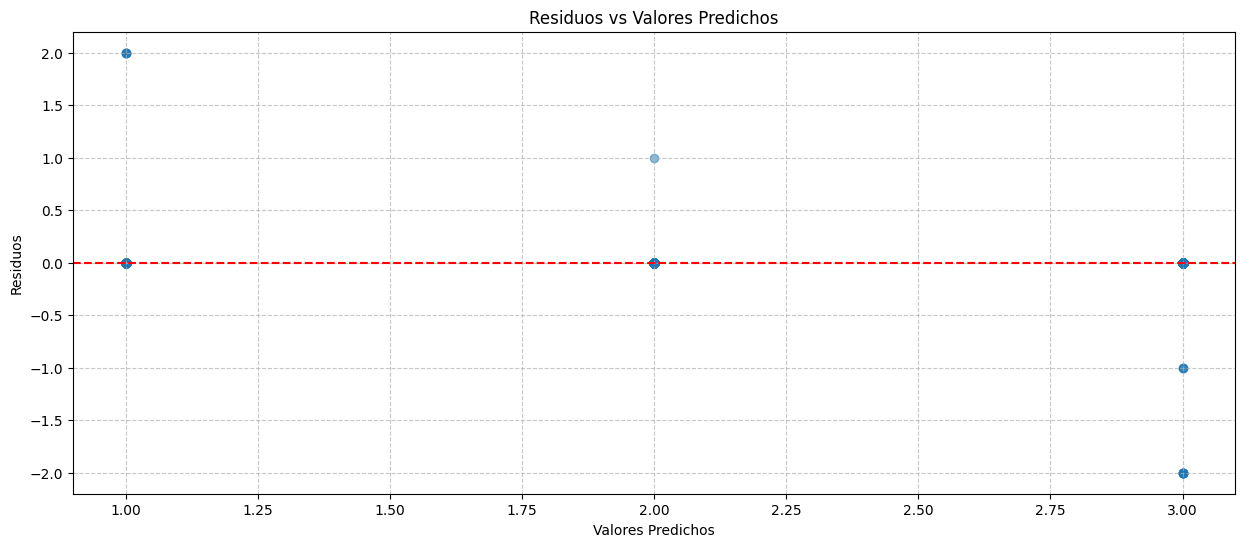

In [108]:
# Calcular residuos
residuals = y_test_numeric - y_pred_numeric
# Crear figura con dos subplots
fig, (ax1) = plt.subplots(1, figsize=(15, 6))

# 1. Gráfico de residuos vs valores predichos
ax1.scatter(y_pred_numeric, residuals, alpha=0.5)
ax1.axhline(y=0, color='r', linestyle='--')
ax1.set_xlabel('Valores Predichos')
ax1.set_ylabel('Residuos')
ax1.set_title('Residuos vs Valores Predichos')
ax1.grid(True, linestyle='--', alpha=0.7)


# Análisis de la Gráfica de Residuos
1. Distribución de Residuos:
- Los residuos se distribuyen alrededor de la línea horizontal en y=0 (línea roja punteada)
- La mayoría de los residuos se concentran en el rango de ±1, lo que indica que las predicciones del modelo generalmente están dentro de una categoría de diferencia
- La gráfica muestra que los residuos están distribuidos alrededor de 0, lo cual es un buen indicador de que el modelo no tiene un sesgo sistemático hacia sobreestimar o subestimar las categorías.
2. Patrones Observados:
- Hay una estructura visible en los residuos debido a la naturaleza categórica de las predicciones (1=Bajo, 2=Medio, 3=Alto)
- Se observan bandas horizontales claras que corresponden a los errores de clasificación entre categorías adyacentes
- Los valores negativos son normales y representan casos donde el modelo predijo una categoría más alta que la real.
3. Magnitud de Errores:
- Los errores más grandes (residuos más alejados de 0) son menos frecuentes
- La mayoría de los errores son de magnitud pequeña, lo que sugiere que el modelo tiende a confundir principalmente categorías adyacentes
- Hay pocos casos de errores extremos (residuos cercanos a ±2), indicando que el modelo raramente confunde categorías no adyacentes (como predecir "Alto" cuando es "Bajo" o viceversa)
### Conclusión General
- El análisis de residuos muestra que el modelo tiene un buen rendimiento general, con la mayoría de los errores siendo relativamente pequeños y sistemáticos. La estructura discreta visible en la gráfica es esperada debido a la naturaleza categórica del problema. El modelo muestra una tendencia a mantener sus errores dentro de categorías adyacentes, lo cual es preferible en un contexto de clasificación ordinal.

### Implicaciones
- El modelo es más confiable para predicciones entre categorías adyacentes
- Los errores grandes son poco frecuentes, lo que sugiere que el modelo es robusto
- La distribución de residuos indica que el modelo es adecuado para la tarea de clasificación, aunque hay espacio para mejoras en la diferenciación entre categorías adyacentes
---

# Evaluacion y Analisis 

In [ ]:

best_model = LGBMClassifier(random_state=42)
best_model.fit(X_train, y_train)

## Conclusión: Despliegue y Documentación del Modelo de Clasificación de Videojuegos

El desarrollo del modelo de clasificación para predecir la variable *rating* ha pasado por diversas etapas, desde la limpieza y preprocesamiento de datos hasta la evaluación de múltiples algoritmos de aprendizaje automático. A continuación, se detallan las acciones clave para su despliegue y documentación:

### 1. Preparación del Modelo para Producción
- Se ha optimizado el código mediante el uso de pipelines, permitiendo una integración eficiente y reproducible del flujo de datos.
- Se ha implementado un pipeline de predicción que encapsula la transformación de datos, selección de características y clasificación final.
- Se ha considerado la mitigación del desbalance de clases con técnicas como *SMOTE*, asegurando una mejor generalización del modelo.

### 2. Documentación del Proceso
- Se han registrado las decisiones tomadas durante el desarrollo, incluyendo la selección de algoritmos y los métodos de evaluación utilizados.
- Se han reportado los resultados obtenidos, con métricas clave como *accuracy*, *F1-score* y matrices de confusión, asegurando una comprensión clara del desempeño del modelo.
- Se han identificado y documentado las limitaciones encontradas, como posibles sesgos en los datos, la necesidad de más características explicativas y la sensibilidad del modelo a ciertos umbrales de clasificación.

### 3. Plan de Monitoreo y Mantenimiento
- Se han definido métricas de seguimiento, como la *drift detection* para identificar posibles cambios en la distribución de datos que podrían afectar el desempeño del modelo.
- Se ha establecido una frecuencia de actualización basada en la recopilación de nuevos datos, con reevaluaciones periódicas del modelo.
- Se han delineado procedimientos de mantenimiento que incluyen el reentrenamiento del modelo en caso de caída en el rendimiento y la revisión de hiperparámetros cuando sea necesario.

Con estos pasos, el modelo queda listo para su implementación en un entorno productivo, asegurando su estabilidad, escalabilidad y capacidad de adaptación a nuevas condiciones del mercado